It would be a very remiss of this analysis if we do not verify the results by another technique. In parallel to the graph-theoric method, in an effort to replicate its results, here I will implement an unsupervised clustering algorithm to reconstruct the same small-world networks.


In [2]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure

from bids import BIDSLayout

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Let's load the time-series of all subjects and all ROIs. In addition to the time-series, pre-computed file contains ROI labels and coords, subject ids, and group assignments (either AVGP or NVGP). We don't use all of them, but let's load them.

In [18]:
layout = BIDSLayout('data/julia2018', derivatives=False)
dataset = xr.open_dataset('data/julia2018_resting/timeseries.nc')

TR = layout.get_tr(task='rest')

timeseries = dataset['timeseries']

subjects = dataset['subject_groups'].to_pandas()
regions = dataset['regions'].to_pandas()

print('Loaded {} subjects, {} regions, and {} timepoints each (TR={}s)'.format(*timeseries.shape, TR))

Loaded 32 subjects, 39 regions, and 125 timepoints each (TR=3.0s)


To confirm, we can plot time-series of a given ROI for a few subjects.

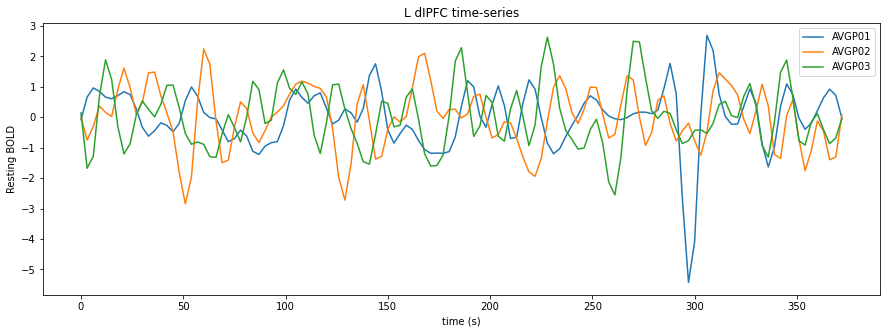

In [39]:
reigon_index_to_plot = 10

timepoints = np.arange(0,timeseries.shape[2] * TR, step=TR)

fig, ax = plt.subplots(figsize=(15, 5))

# plot timeseries
for i, (subj, grp) in enumerate(subjects.head(3).iteritems()):
    sns.lineplot(x=timepoints,
                 y=timeseries[i,reigon_index_to_plot,:],
                 ax=ax, label=subj)


ax.set(title='{} time-series'.format(regions.iloc[reigon_index_to_plot].name),
       xlabel='time (s)',
       ylabel='Resting BOLD')


plt.show()

One early use of hierarchical clustering to resting-state data was [aa](http://). They introduced a distance function, cc, defined as the frequency differences of two time-series. Dosenbach and crews used similar distance measure of `1-r`, which allows us to use covariate matrices to calculate clusters.

Before using `1-r` as a distance function, let's implement the original method which used frequency-domain similarity. This is just for demostration and for now we will not use this distance function.

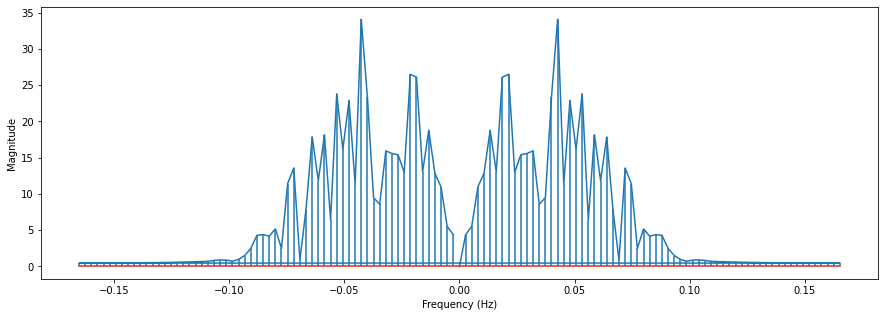

In [45]:
from scipy import fftpack

subject_index = 0
reigon_index = 0
signal = timeseries.values[subject_index, reigon_index,:]

samping_rate = 1/TR
X = fftpack.fft(signal)
freqs = fftpack.fftfreq(len(signal)) * samping_rate

fig, ax = plt.subplots(figsize=(15,5))

ax.stem(freqs, np.abs(X), markerfmt='')
ax.set(xlabel='Frequency (Hz)', ylabel='Magnitude')

plt.show()

Now will will bootstrap the subjects 1000 times (with replacement), and compute the aveerage connectivity matrix between ROIs.

Bootstrapping also allows us to see how many times two regions are in the same clusters; assuming there will be aways 8 clusters of regions in all the 1000 bootstrapped samples.

subject
NVGP08       NVGP
AVGP04       AVGP
NVGP08       NVGP
AVGP04       AVGP
NVGP08       NVGP
AVGP18       AVGP
NVGP12       NVGP
NVGP03       NVGP
AVGP05       AVGP
AVGP17NEW    AVGP
dtype: object

In [90]:
from tqdm import tqdm

def mean_connectome(timeseries):
    """This function computes connectivity matrix of all ROIs."""
    
    cm = ConnectivityMeasure(kind='correlation')
    X = [s.T for s in timeseries.values]    
    _ = cm.fit_transform(X)
    mean_conn = cm.mean_
    # np.fill_diagonal(mean_conn, 0)  # improves visualization!
    return mean_conn

boot_connectomes = []   # boostrapped connectomes
boot_clusters = []      # boostrapped cluster assignments of each ROI
n_boostraps = 1000      # number of boostrapped samples
n_clusters = 8          # maximum number of clusters

from scipy.spatial.distance import squareform

for i in tqdm(range(n_boostraps)):
    boot_subjects_idx = subjects.reset_index().sample(len(subjects), replace=True).index.values
    conn = mean_connectome(timeseries[boot_subjects_idx,:,:])
    boot_connectomes.append(conn)
    distances = 1.0 - conn
    linkages = linkage(squareform(distances), 'average')
    clusters = fcluster(linkages, t=n_clusters, criterion='maxclust')
    boot_clusters.append(clusters)
boot_clusters = np.asarray(boot_clusters)

100%|██████████| 1000/1000 [00:18<00:00, 53.17it/s]


We can now plot number of times that two given nodes were clustered together (out of 1000).

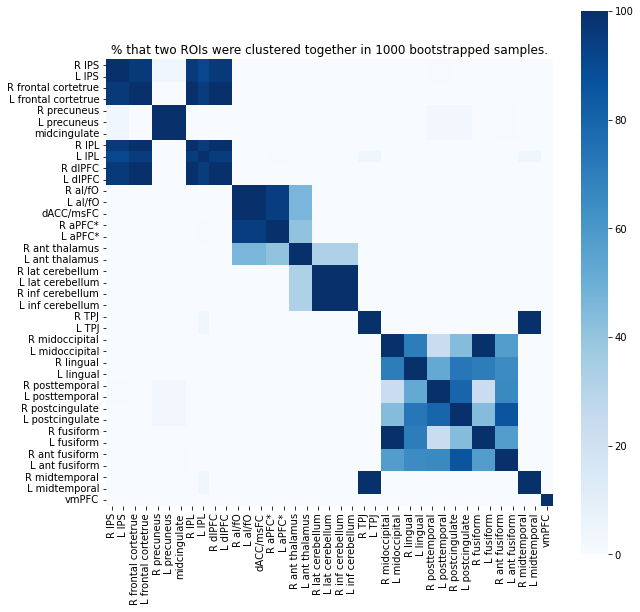

In [112]:
n_regions = regions.shape[0]

n_clustered_together = np.zeros((n_regions, n_regions))

for i in range(39):
    n_clustered_together[i,i] = 1000
    for j in range(i):
        n_clustered_together[j,i] = n_clustered_together[i,j] = np.sum(boot_clusters[:,i] == boot_clusters[:,j])

pct_clustered_together = 100 * n_clustered_together / n_boostraps

# plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(pct_clustered_together,
            square=True,
            yticklabels=regions.index,
            xticklabels=regions.index,
            cmap='Blues',
            ax=ax)
ax.set(title='% that two ROIs were clustered together in 1000 bootstrapped samples.')
plt.show()

Finally, figures below shows the group-averaged clusters in 1000 bootstrapped samples.

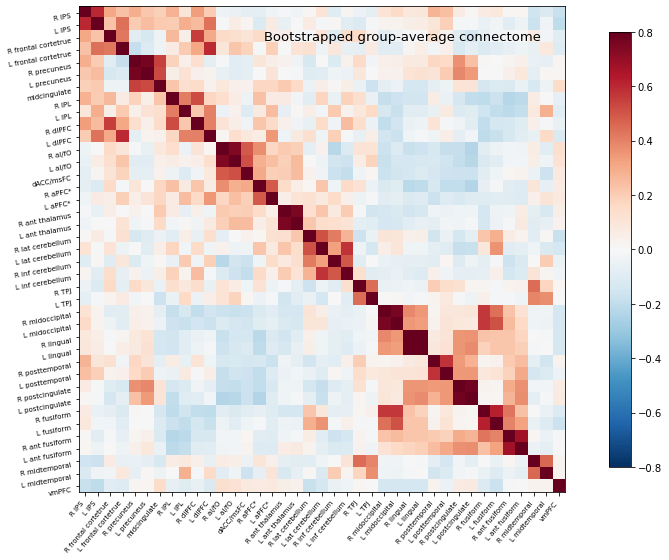

In [111]:
mean_conn = np.mean(boot_connectomes, axis=0)

fig, _ = plt.subplots(figsize=(10,10))
plotting.plot_matrix(mean_conn, labels=regions.index.to_list(),
                     title='Bootstrapped group-average connectome',
                     vmax=.8, vmin=-.8,
                     figure=fig,
                     colorbar=True)

plt.show()
